🔄 Cleaning outliers with Isolation Forest...

📊 Read Bytes:
  CPU_STRESS: Removed 0 outliers (0.0%) using 4 features
  BASELINE: Removed 0 outliers (0.0%) using 4 features

📊 Write Bytes:
  CPU_STRESS: Removed 15 outliers (3.1%) using 4 features
  BASELINE: Removed 13 outliers (2.7%) using 4 features

📊 Block Count Latency Device:
  CPU_STRESS: Removed 3 outliers (0.6%) using 1 features
  BASELINE: Removed 7 outliers (1.4%) using 1 features

🎯 I/O FEATURE VISUALIZATION


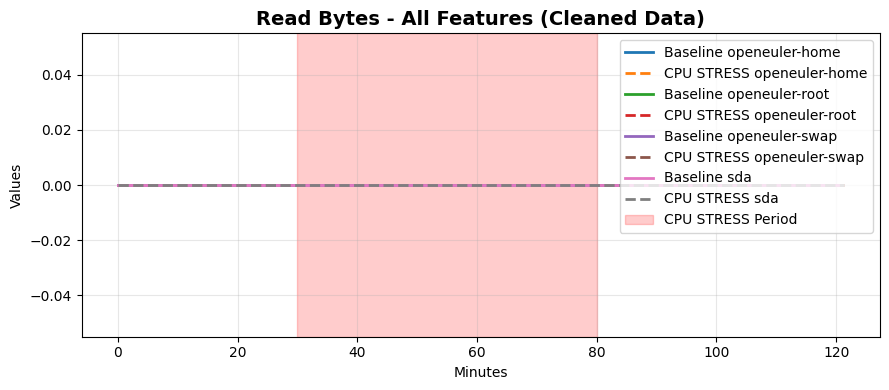

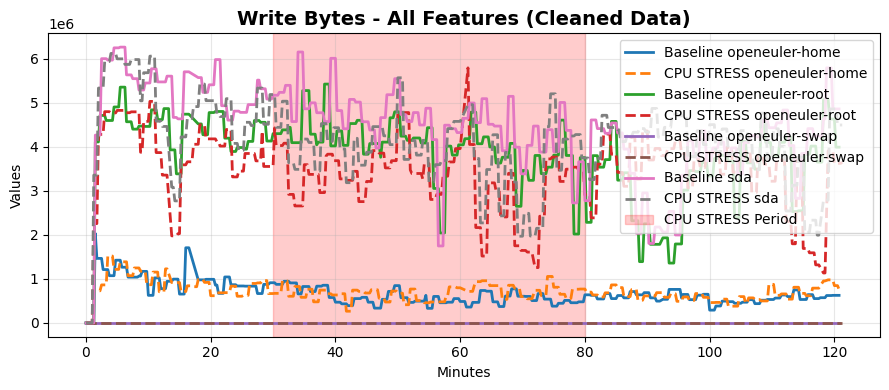


🎯 IO CPU STRESS ANALYSIS - COMPLETE 6-PLOT VISUALIZATION

🔄 Analyzing Read Bytes...


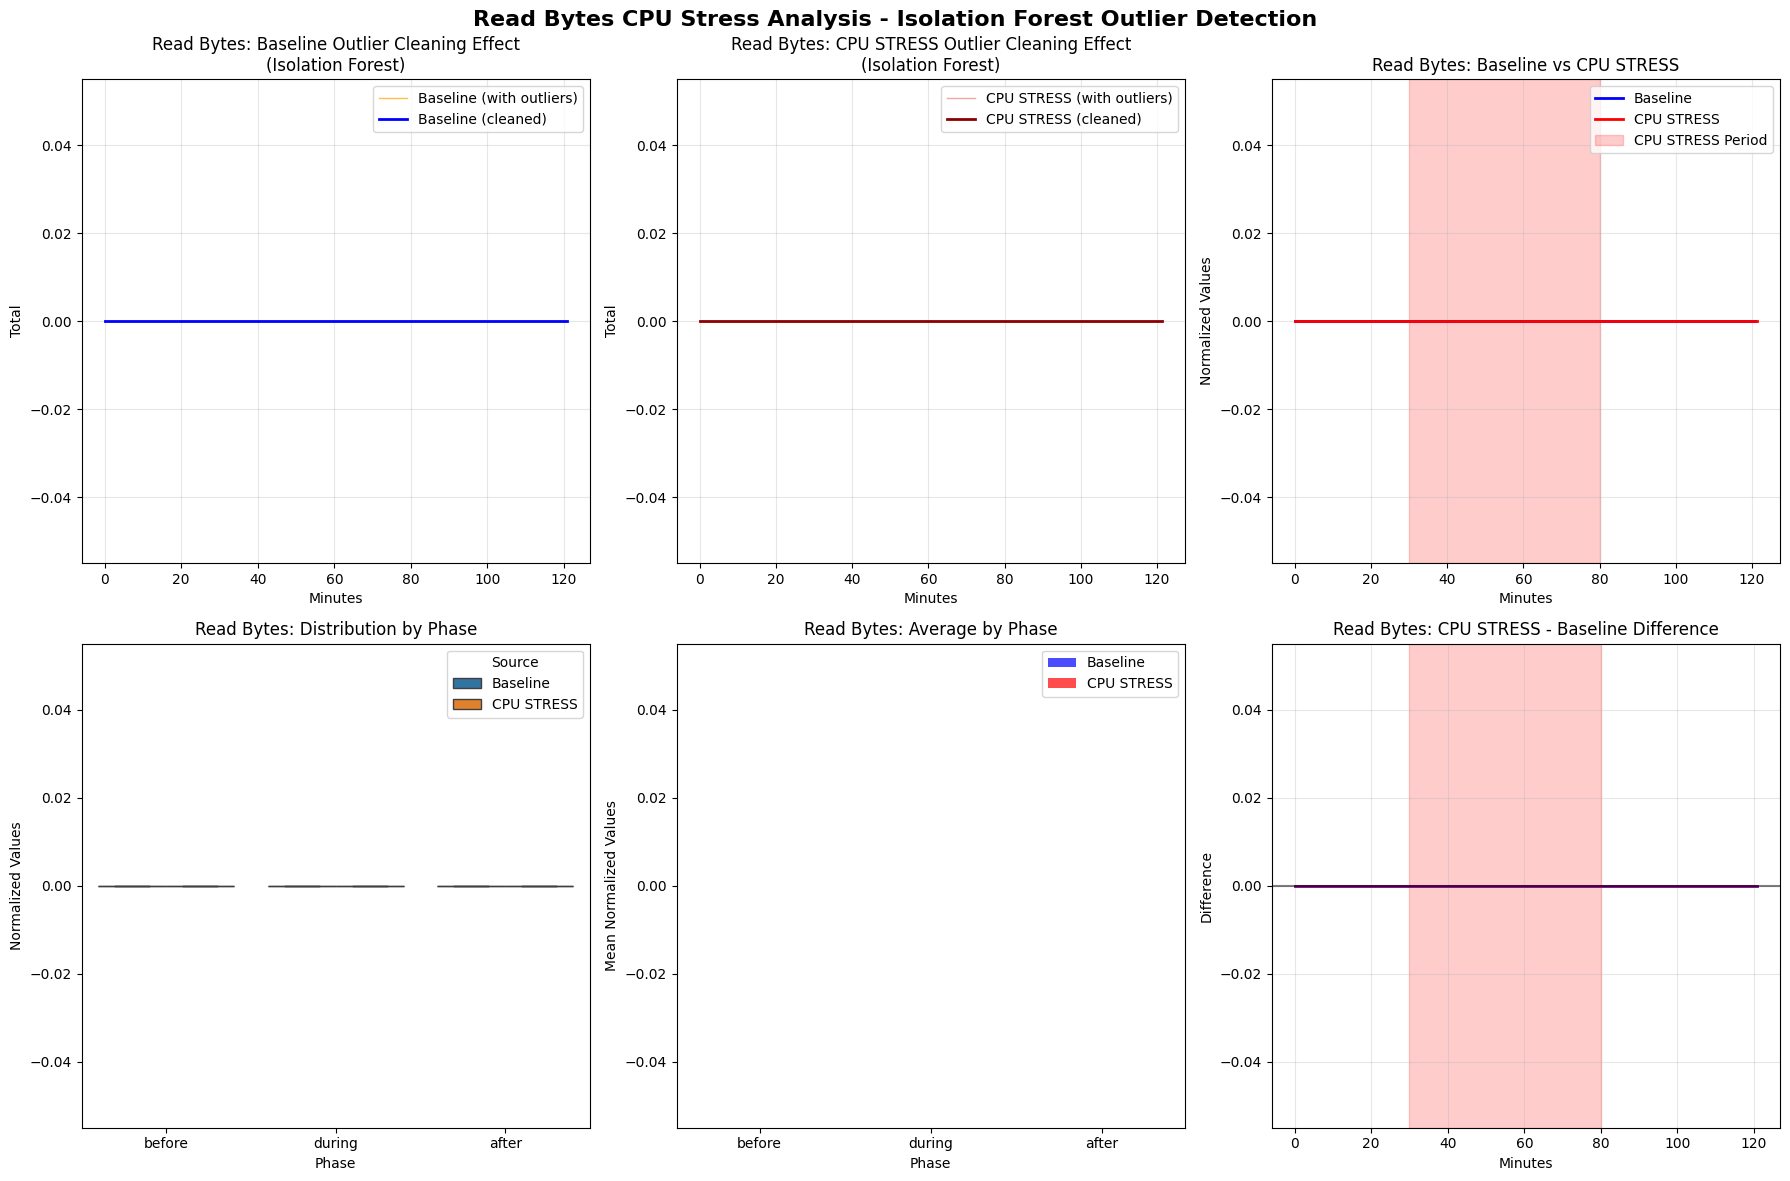


📊 READ BYTES STATISTICAL ANALYSIS:

BEFORE phase:
  Baseline: mean=0.0000, std=0.0000
  CPU STRESS: mean=0.0000, std=0.0000
  Change: +0.00%
  T-test: t=nan, p=nan (❌ NOT SIGNIFICANT)

DURING phase:
  Baseline: mean=0.0000, std=0.0000
  CPU STRESS: mean=0.0000, std=0.0000
  Change: +0.00%
  T-test: t=nan, p=nan (❌ NOT SIGNIFICANT)

AFTER phase:
  Baseline: mean=0.0000, std=0.0000
  CPU STRESS: mean=0.0000, std=0.0000
  Change: +0.00%
  T-test: t=nan, p=nan (❌ NOT SIGNIFICANT)

🔄 Analyzing Write Bytes...


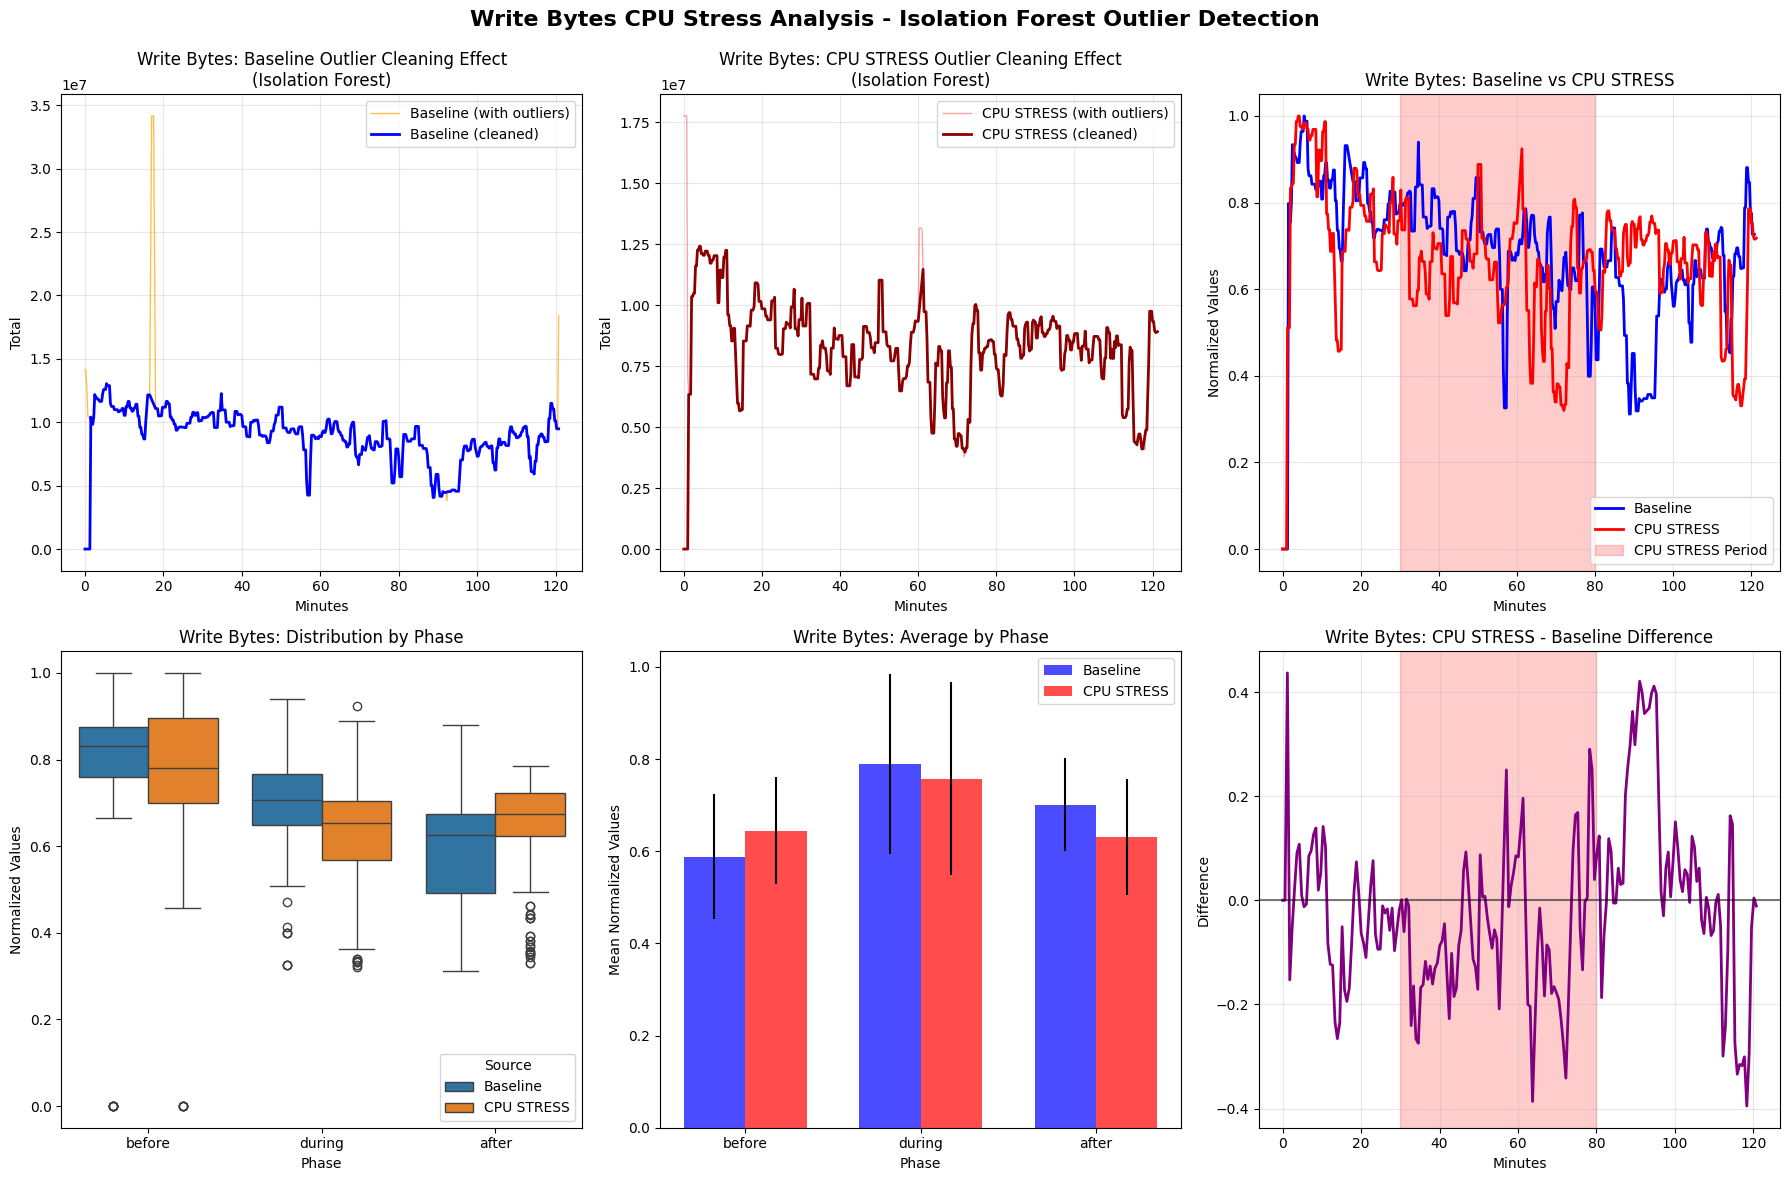


📊 WRITE BYTES STATISTICAL ANALYSIS:

BEFORE phase:
  Baseline: mean=0.7895, std=0.1952
  CPU STRESS: mean=0.7570, std=0.2094
  Change: -4.11%
  T-test: t=1.241, p=0.2160 (❌ NOT SIGNIFICANT)

DURING phase:
  Baseline: mean=0.7008, std=0.1011
  CPU STRESS: mean=0.6305, std=0.1257
  Change: -10.03%
  T-test: t=6.177, p=0.0000 (✅ SIGNIFICANT)

AFTER phase:
  Baseline: mean=0.5885, std=0.1347
  CPU STRESS: mean=0.6449, std=0.1156
  Change: +9.58%
  T-test: t=-4.070, p=0.0001 (✅ SIGNIFICANT)

🔄 Analyzing Block Count Latency Device...


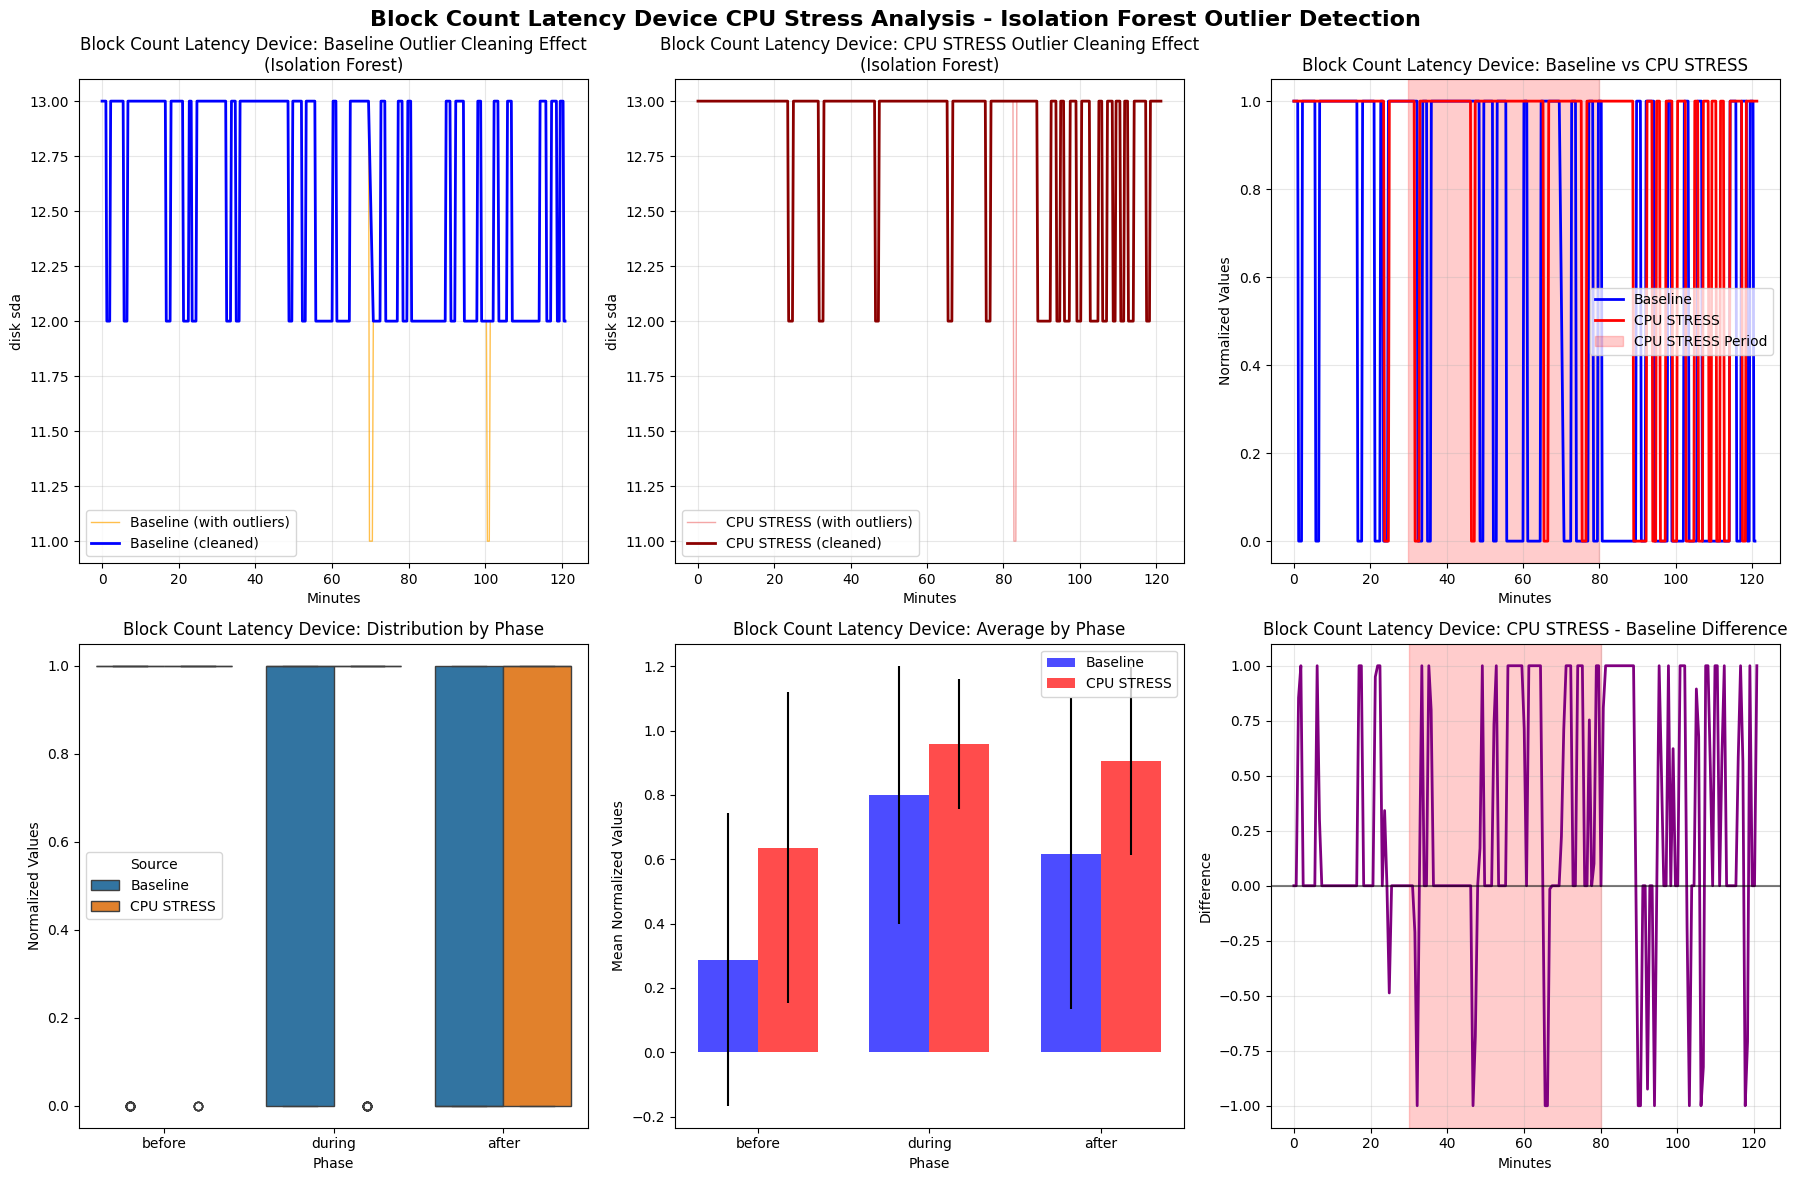


📊 BLOCK COUNT LATENCY DEVICE STATISTICAL ANALYSIS:

BEFORE phase:
  Baseline: mean=0.8000, std=0.4017
  CPU STRESS: mean=0.9583, std=0.2007
  Change: +19.79%
  T-test: t=-3.863, p=0.0001 (✅ SIGNIFICANT)

DURING phase:
  Baseline: mean=0.6169, std=0.4832
  CPU STRESS: mean=0.9055, std=0.2933
  Change: +46.77%
  T-test: t=-7.237, p=0.0000 (✅ SIGNIFICANT)

AFTER phase:
  Baseline: mean=0.2883, std=0.4544
  CPU STRESS: mean=0.6364, std=0.4825
  Change: +120.70%
  T-test: t=-6.723, p=0.0000 (✅ SIGNIFICANT)

ISOLATION FOREST OUTLIER DETECTION SUMMARY

📊 READ BYTES:
  CPU_STRESS:
    Total outliers removed: 0
    Percentage removed: 0.0%
    Features used: 4
    Contamination rate: 3.0%
  BASELINE:
    Total outliers removed: 0
    Percentage removed: 0.0%
    Features used: 4
    Contamination rate: 3.0%

📊 WRITE BYTES:
  CPU_STRESS:
    Total outliers removed: 15
    Percentage removed: 3.1%
    Features used: 4
    Contamination rate: 3.0%
  BASELINE:
    Total outliers removed: 13
    Pe

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all IO datasets
df_block_count_latency_device = pd.read_csv("block_count_latency_device.csv")
df_read_bytes = pd.read_csv("read_bytes.csv")
df_write_bytes = pd.read_csv("write_bytes.csv")

df_baseline_block_count_latency_device = pd.read_csv("../../baseline/IO related/block_count_latency_device.csv")
df_baseline_read_bytes = pd.read_csv("../../baseline/IO related/read_bytes.csv")
df_baseline_write_bytes = pd.read_csv("../../baseline/IO related/write_bytes.csv")

# Add source labels for tracking
df_block_count_latency_device["source"] = "CPU_STRESS"
df_read_bytes["source"] = "CPU_STRESS"
df_write_bytes["source"] = "CPU_STRESS"

df_baseline_block_count_latency_device["source"] = "BASELINE"
df_baseline_read_bytes["source"] = "BASELINE"
df_baseline_write_bytes["source"] = "BASELINE"

# Convert to datetime
datasets = [
    df_block_count_latency_device, df_read_bytes, df_write_bytes,
    df_baseline_block_count_latency_device, df_baseline_read_bytes, df_baseline_write_bytes
]

for df in datasets:
    df["Time"] = pd.to_datetime(df["Time"])

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_block_count_latency_device["Time"].min() - df_block_count_latency_device["Time"].min()
df_block_count_latency_device["Time"] += time_offset
df_read_bytes["Time"] += time_offset
df_write_bytes["Time"] += time_offset

# Create Minutes column for all datasets
for df in datasets:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

delay = 30  # 30 minutes
duration = 50  # 50 minutes

# STORE ORIGINAL DATASETS BEFORE CLEANING
original_datasets = {
    'Read Bytes': {
        'baseline': df_baseline_read_bytes.copy(),
        'cpu_stress': df_read_bytes.copy()
    },
    'Write Bytes': {
        'baseline': df_baseline_write_bytes.copy(),
        'cpu_stress': df_write_bytes.copy()
    },
    'Block Count Latency Device': {
        'baseline': df_baseline_block_count_latency_device.copy(),
        'cpu_stress': df_block_count_latency_device.copy()
    }
}

# Simple Isolation Forest outlier removal with statistics tracking
def remove_outliers_isolation_forest(df, contamination=0.03):
    """Remove outliers using Isolation Forest and return statistics"""
    df_clean = df.copy()
    outlier_stats = {}
    
    # Get numeric columns (exclude Time and Minutes)
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        outlier_stats['total_outliers'] = 0
        outlier_stats['contamination_rate'] = contamination
        outlier_stats['features_used'] = 0
        return df_clean, outlier_stats
    
    # Prepare feature matrix
    feature_matrix = df[numeric_cols].fillna(0).values
    
    # Check if there's enough variance to detect outliers
    if np.std(feature_matrix.flatten()) > 1e-10:
        # Scale features
        scaler = StandardScaler()
        feature_matrix_scaled = scaler.fit_transform(feature_matrix)
        
        # Apply Isolation Forest
        iso_forest = IsolationForest(
            contamination=contamination,
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        
        iso_forest.fit(feature_matrix_scaled)
        outlier_predictions = iso_forest.predict(feature_matrix_scaled)
        outlier_mask = outlier_predictions == -1
        
        # Remove outliers and interpolate
        for col in numeric_cols:
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].interpolate(method='linear').fillna(0)
        
        # Track statistics
        outlier_stats['total_outliers'] = outlier_mask.sum()
        outlier_stats['contamination_rate'] = contamination
        outlier_stats['features_used'] = len(numeric_cols)
        outlier_stats['percentage_removed'] = (outlier_mask.sum() / len(df)) * 100
    else:
        outlier_stats['total_outliers'] = 0
        outlier_stats['contamination_rate'] = contamination
        outlier_stats['features_used'] = len(numeric_cols)
        outlier_stats['percentage_removed'] = 0
    
    return df_clean, outlier_stats

# Clean all datasets and track statistics
print("🔄 Cleaning outliers with Isolation Forest...")

all_outlier_stats = {}

df_read_bytes_clean, read_stats = remove_outliers_isolation_forest(df_read_bytes)
df_write_bytes_clean, write_stats = remove_outliers_isolation_forest(df_write_bytes)
df_block_count_latency_device_clean, block_stats = remove_outliers_isolation_forest(df_block_count_latency_device)

df_baseline_read_bytes_clean, baseline_read_stats = remove_outliers_isolation_forest(df_baseline_read_bytes)
df_baseline_write_bytes_clean, baseline_write_stats = remove_outliers_isolation_forest(df_baseline_write_bytes)
df_baseline_block_count_latency_device_clean, baseline_block_stats = remove_outliers_isolation_forest(df_baseline_block_count_latency_device)

# Store cleaning statistics
all_outlier_stats = {
    'Read Bytes': {'cpu_stress': read_stats, 'baseline': baseline_read_stats},
    'Write Bytes': {'cpu_stress': write_stats, 'baseline': baseline_write_stats},
    'Block Count Latency Device': {'cpu_stress': block_stats, 'baseline': baseline_block_stats}
}

# Print cleaning summary
for dataset_name, stats in all_outlier_stats.items():
    print(f"\n📊 {dataset_name}:")
    for condition, stat in stats.items():
        print(f"  {condition.upper()}: Removed {stat['total_outliers']} outliers ({stat['percentage_removed']:.1f}%) using {stat['features_used']} features")

# Normalization function
def normalize_df(df, columns):
    """Normalize columns to 0-1 range"""
    df_norm = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            df_norm[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0
    return df_norm

# Phase definition function
def define_phases(df, delay_minutes, duration_minutes):
    conditions = [
        df['Minutes'] < delay_minutes,
        (df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes),
        df['Minutes'] > delay_minutes + duration_minutes
    ]
    choices = ['before', 'during', 'after']
    df['Phase'] = np.select(conditions, choices, default='unknown')
    return df

# Complete analysis function with 6-plot layout (FIXED)
def analyze_io_dataset_complete(baseline_df_clean, test_df_clean, dataset_name, test_label="CPU STRESS"):
    
    # Get original datasets for comparison
    baseline_df_original = original_datasets[dataset_name]['baseline']
    test_df_original = original_datasets[dataset_name]['cpu_stress']
    
    # Get numeric columns (create Total if multiple columns exist)
    numeric_cols = [col for col in baseline_df_clean.columns 
                   if col not in ['Time', 'Minutes', 'source', 'Phase'] and baseline_df_clean[col].dtype in ['int64', 'float64']]
    
    if not numeric_cols:
        print(f"❌ No numeric columns found for {dataset_name}")
        return
    
    # If multiple columns, create Total column
    if len(numeric_cols) > 1:
        baseline_df_clean['Total'] = baseline_df_clean[numeric_cols].sum(axis=1)
        test_df_clean['Total'] = test_df_clean[numeric_cols].sum(axis=1)
        baseline_df_original['Total'] = baseline_df_original[numeric_cols].sum(axis=1)
        test_df_original['Total'] = test_df_original[numeric_cols].sum(axis=1)
        main_col = 'Total'
    else:
        main_col = numeric_cols[0]
    
    # Normalize data
    baseline_norm = normalize_df(baseline_df_clean, [main_col])
    test_norm = normalize_df(test_df_clean, [main_col])
    
    # Define phases
    baseline_norm = define_phases(baseline_norm, delay, duration)
    test_norm = define_phases(test_norm, delay, duration)
    
    # Create the 6-subplot figure
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle(f'{dataset_name} CPU Stress Analysis - Isolation Forest Outlier Detection', fontsize=16, fontweight='bold')
    
    # Plot 1: Baseline Cleaning Effect (top-left) - FIXED
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(baseline_df_original['Minutes'], baseline_df_original[main_col], color='orange', alpha=0.7, linewidth=1, label=f'Baseline (with outliers)')
    plt.plot(baseline_df_clean['Minutes'], baseline_df_clean[main_col], color='blue', linewidth=2, label='Baseline (cleaned)')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect\n(Isolation Forest)')
    plt.xlabel('Minutes')
    plt.ylabel(f'{main_col}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Test Cleaning Effect (top-center) - FIXED
    ax2 = plt.subplot(2, 3, 2)
    plt.plot(test_df_original['Minutes'], test_df_original[main_col], color='lightcoral', alpha=0.7, linewidth=1, label=f'{test_label} (with outliers)')
    plt.plot(test_df_clean['Minutes'], test_df_clean[main_col], color='darkred', linewidth=2, label=f'{test_label} (cleaned)')
    plt.title(f'{dataset_name}: {test_label} Outlier Cleaning Effect\n(Isolation Forest)')
    plt.xlabel('Minutes')
    plt.ylabel(f'{main_col}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Baseline vs Test Comparison (top-right)
    ax3 = plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm[main_col], color='blue', linewidth=2, label='Baseline')
    plt.plot(test_norm['Minutes'], test_norm[main_col], color='red', linewidth=2, label=test_label)
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label=f'{test_label} Period')
    plt.title(f'{dataset_name}: Baseline vs {test_label}')
    plt.xlabel('Minutes')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Prepare data for phase analysis
    baseline_phase_data = []
    test_phase_data = []
    phases = ['before', 'during', 'after']
    
    for phase in phases:
        baseline_phase_values = baseline_norm[baseline_norm['Phase'] == phase][main_col]
        test_phase_values = test_norm[test_norm['Phase'] == phase][main_col]
        
        baseline_phase_data.extend([(phase, val, 'Baseline') for val in baseline_phase_values])
        test_phase_data.extend([(phase, val, test_label) for val in test_phase_values])
    
    # Combine phase data
    all_phase_data = baseline_phase_data + test_phase_data
    phase_df = pd.DataFrame(all_phase_data, columns=['Phase', 'Value', 'Source'])
    
    # Plot 4: Distribution by Phase (bottom-left)
    ax4 = plt.subplot(2, 3, 4)
    sns.boxplot(data=phase_df, x='Phase', y='Value', hue='Source', ax=ax4)
    plt.title(f'{dataset_name}: Distribution by Phase')
    plt.ylabel('Normalized Values')
    plt.xlabel('Phase')
    
    # Plot 5: Average by Phase (bottom-center)
    ax5 = plt.subplot(2, 3, 5)
    phase_means = phase_df.groupby(['Phase', 'Source'])['Value'].agg(['mean', 'std']).reset_index()
    
    x_pos = np.arange(len(phases))
    width = 0.35
    
    baseline_means = phase_means[phase_means['Source'] == 'Baseline']['mean'].values
    baseline_stds = phase_means[phase_means['Source'] == 'Baseline']['std'].values
    test_means = phase_means[phase_means['Source'] == test_label]['mean'].values
    test_stds = phase_means[phase_means['Source'] == test_label]['std'].values
    
    plt.bar(x_pos - width/2, baseline_means, width, yerr=baseline_stds, label='Baseline', color='blue', alpha=0.7)
    plt.bar(x_pos + width/2, test_means, width, yerr=test_stds, label=test_label, color='red', alpha=0.7)
    
    plt.title(f'{dataset_name}: Average by Phase')
    plt.ylabel('Mean Normalized Values')
    plt.xlabel('Phase')
    plt.xticks(x_pos, phases)
    plt.legend()
    
    # Plot 6: Difference Over Time (bottom-right)
    ax6 = plt.subplot(2, 3, 6)
    
    # Interpolate to same time points for difference calculation
    common_minutes = np.linspace(0, min(baseline_norm['Minutes'].max(), test_norm['Minutes'].max()), 200)
    baseline_interp = np.interp(common_minutes, baseline_norm['Minutes'], baseline_norm[main_col])
    test_interp = np.interp(common_minutes, test_norm['Minutes'], test_norm[main_col])
    difference = test_interp - baseline_interp
    
    plt.plot(common_minutes, difference, color='purple', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label=f'{test_label} Period')
    plt.title(f'{dataset_name}: {test_label} - Baseline Difference')
    plt.xlabel('Minutes')
    plt.ylabel('Difference')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print(f"\n📊 {dataset_name.upper()} STATISTICAL ANALYSIS:")
    print("=" * 50)
    
    for phase in phases:
        baseline_phase_values = baseline_norm[baseline_norm['Phase'] == phase][main_col].dropna()
        test_phase_values = test_norm[test_norm['Phase'] == phase][main_col].dropna()
        
        if len(baseline_phase_values) > 5 and len(test_phase_values) > 5:
            # T-test
            t_stat, p_value = scipy_stats.ttest_ind(baseline_phase_values, test_phase_values)
            significance = "✅ SIGNIFICANT" if p_value < 0.05 else "❌ NOT SIGNIFICANT"
            
            # Calculate statistics
            baseline_mean = baseline_phase_values.mean()
            test_mean = test_phase_values.mean()
            change = ((test_mean - baseline_mean) / baseline_mean * 100) if baseline_mean != 0 else 0
            
            print(f"\n{phase.upper()} phase:")
            print(f"  Baseline: mean={baseline_mean:.4f}, std={baseline_phase_values.std():.4f}")
            print(f"  {test_label}: mean={test_mean:.4f}, std={test_phase_values.std():.4f}")
            print(f"  Change: {change:+.2f}%")
            print(f"  T-test: t={t_stat:.3f}, p={p_value:.4f} ({significance})")

# FIXED: Use consistent cleaned data for feature visualization
def plot_features_together(baseline_df, test_df, dataset_name, test_label="CPU STRESS", delay=30, duration=50):
    numeric_cols = [col for col in baseline_df.columns 
                   if col not in ['Time', 'Minutes', 'source', 'Phase'] and 
                   baseline_df[col].dtype in ['int64', 'float64']]
    
    if not numeric_cols:
        print(f"No numeric columns found for {dataset_name}")
        return
    
    plt.figure(figsize=(9, 4))
    
    for col in numeric_cols:
        plt.plot(baseline_df['Minutes'], baseline_df[col], 
                label=f'Baseline {col}', linewidth=2, linestyle='-')
        plt.plot(test_df['Minutes'], test_df[col], 
                label=f'{test_label} {col}', linewidth=2, linestyle='--')
    
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, 
               label=f'{test_label} Period')
    
    plt.title(f'{dataset_name} - All Features (Cleaned Data)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# FIXED: Datasets to analyze with proper cleaned data
datasets_to_analyze = [
    (df_baseline_read_bytes_clean, df_read_bytes_clean, "Read Bytes"),
    (df_baseline_write_bytes_clean, df_write_bytes_clean, "Write Bytes"), 
    (df_baseline_block_count_latency_device_clean, df_block_count_latency_device_clean, "Block Count Latency Device")
]

# Run feature plots with cleaned data
print("\n🎯 I/O FEATURE VISUALIZATION")
print("=" * 50)
plot_features_together(df_baseline_read_bytes_clean, df_read_bytes_clean, "Read Bytes", "CPU STRESS")
plot_features_together(df_baseline_write_bytes_clean, df_write_bytes_clean, "Write Bytes", "CPU STRESS")

print("\n🎯 IO CPU STRESS ANALYSIS - COMPLETE 6-PLOT VISUALIZATION")
print("=" * 70)

for baseline_df, test_df, dataset_name in datasets_to_analyze:
    print(f"\n🔄 Analyzing {dataset_name}...")
    analyze_io_dataset_complete(baseline_df, test_df, dataset_name, "CPU STRESS")

# OUTLIER DETECTION SUMMARY
print(f"\n{'='*80}")
print("ISOLATION FOREST OUTLIER DETECTION SUMMARY")
print(f"{'='*80}")

for dataset_name, stats in all_outlier_stats.items():
    print(f"\n📊 {dataset_name.upper()}:")
    for condition, stat in stats.items():
        print(f"  {condition.upper()}:")
        print(f"    Total outliers removed: {stat['total_outliers']}")
        print(f"    Percentage removed: {stat['percentage_removed']:.1f}%")
        print(f"    Features used: {stat['features_used']}")
        print(f"    Contamination rate: {stat['contamination_rate']*100:.1f}%")